In [1]:
import nibabel as nib
a = nib.load('data/Train/001/001_ES.nii').get_fdata()

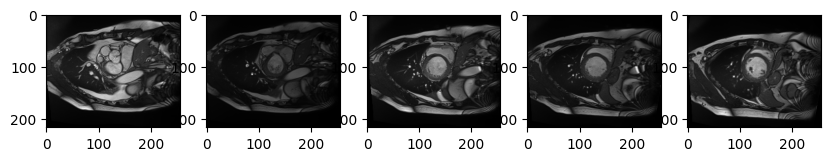

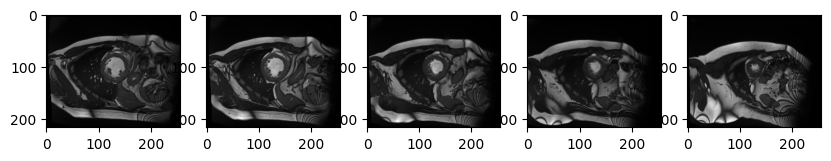

In [2]:
import matplotlib.pyplot as plt
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(a[:,:,0 + i], cmap='gray')
    plt.gcf().set_size_inches(10, 10)
plt.show()
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(a[:,:,5 + i], cmap='gray')
    plt.gcf().set_size_inches(10, 10)
plt.show()